In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

## Fit a Bernoulli GLNEM

In [2]:
from glnem.datasets import load_ppnetwork
from glnem import GLNEM

Y = load_ppnetwork(connected_component=True)

In [6]:
model_ss = GLNEM(family='bernoulli', link='logit', n_features=10)
model_ss.sample(Y, n_warmup=7500, n_samples=15000)

sample: 100%|██████████████████████████████████████| 22500/22500 [59:18<00:00,  6.32it/s, 63 steps of size 7.97e-02. acc. prob=0.86]


## Diagnostic Plots (Figure S16)

<IPython.core.display.Javascript object>


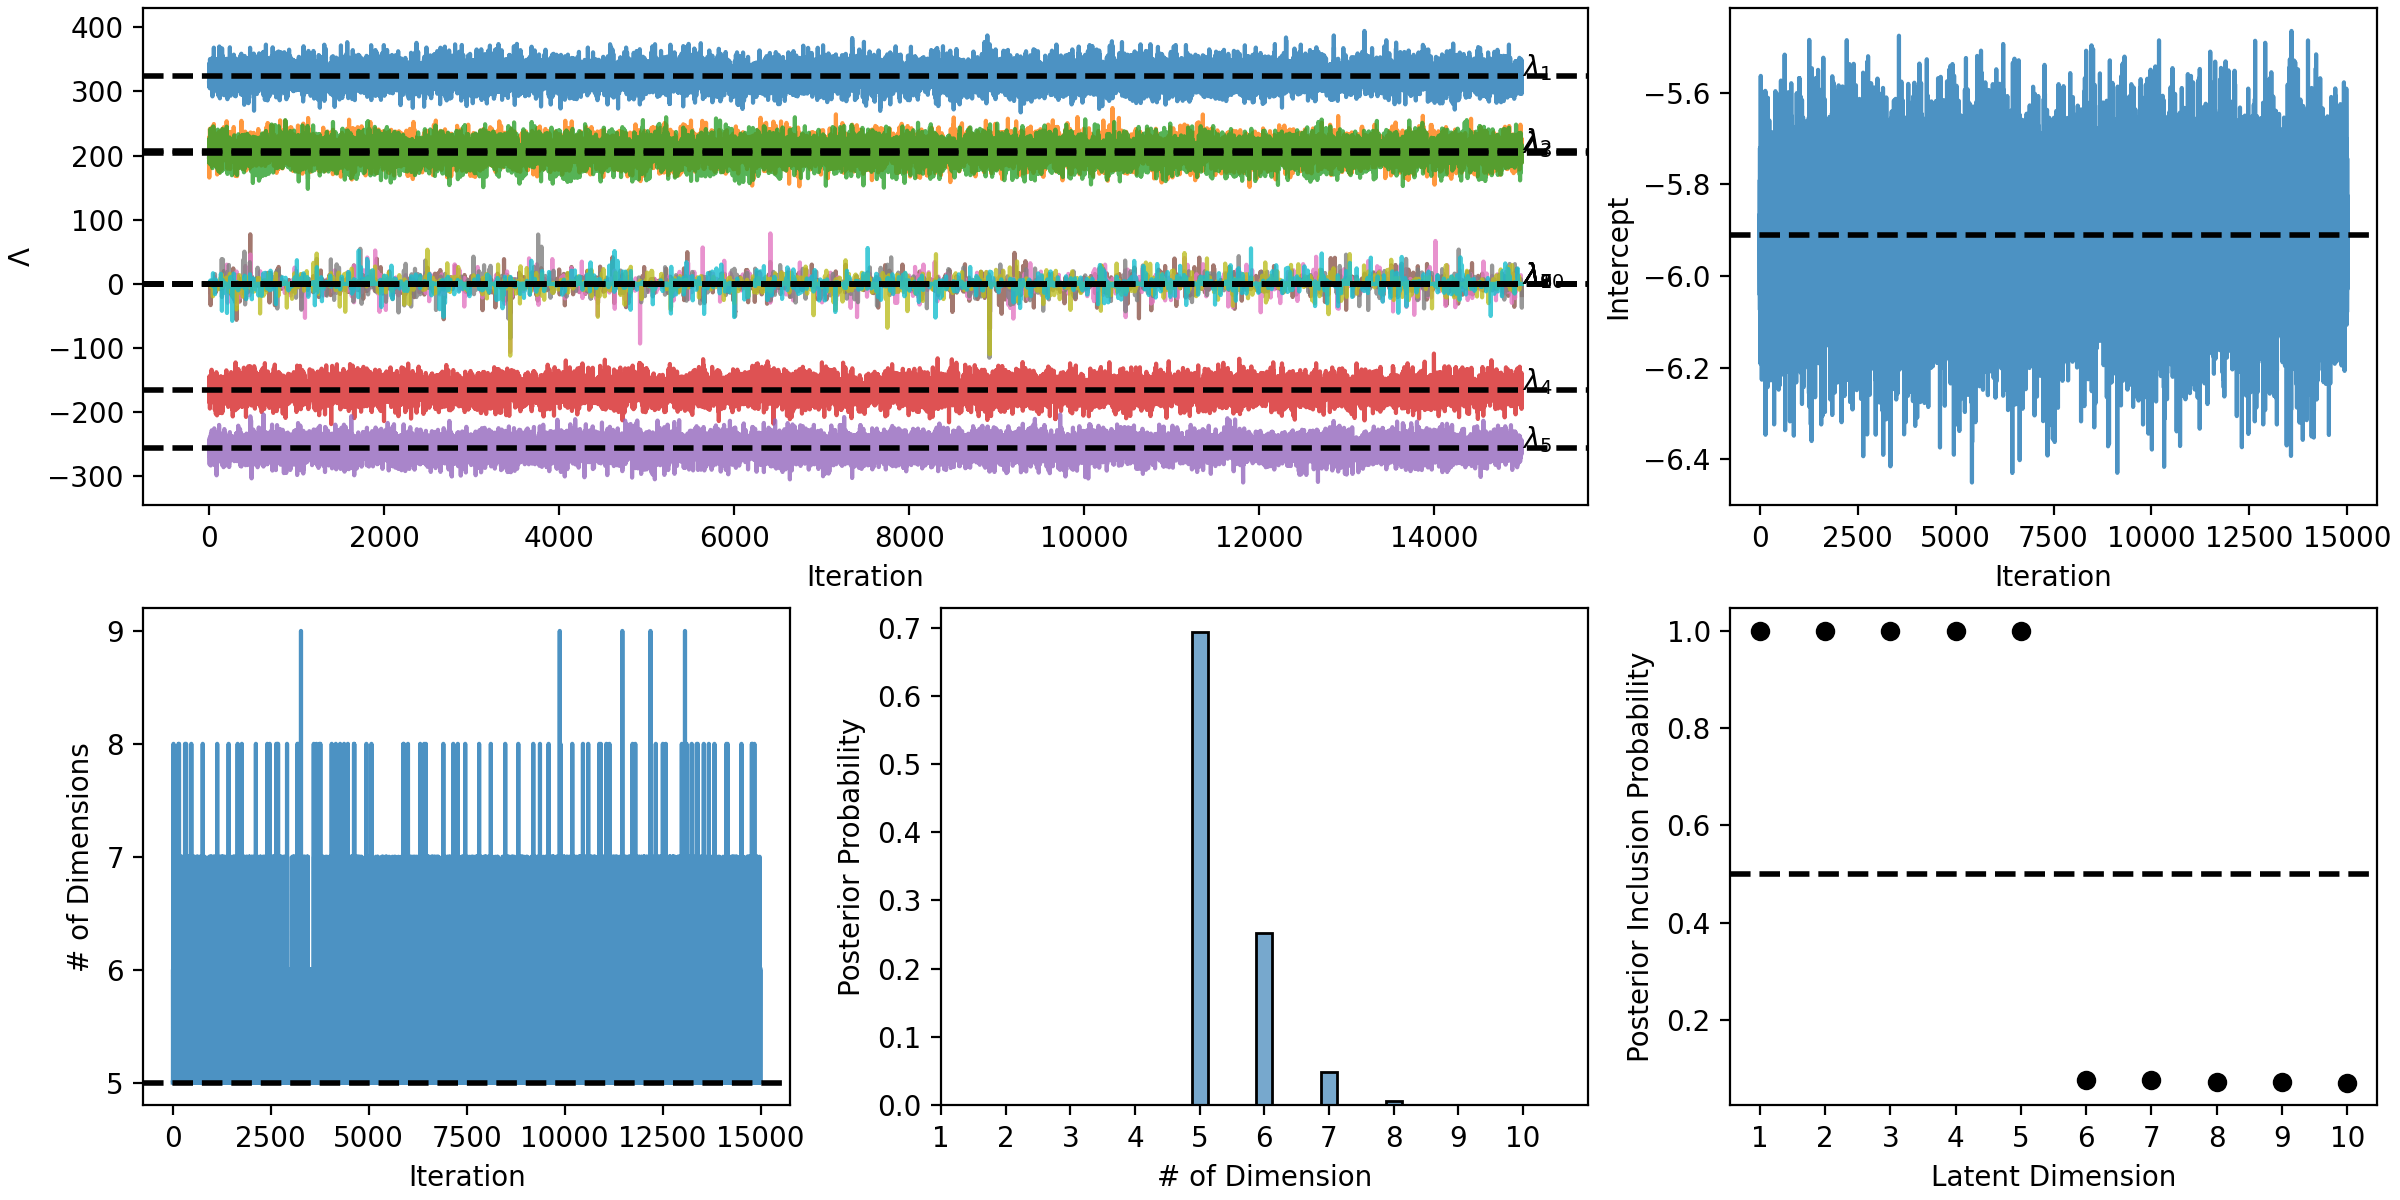

In [12]:
ax = model_ss.plot(Y_obs=Y, include_diagnostics=False, figsize=(12,6))

## K-Fold CV Dimension Selection (Gaussian Prior)

In [ ]:
from glnem.model_selection import kfold_selection

res = kfold_selection(Y, family='bernoulli', link='logit',
                      max_features=10, n_folds=4,
                      n_warmup=7500, n_samples=15000)

## K-Fold Cross-Validation Results (Figure S3)

Text(0, 0.5, 'K-Fold CV Log-Likelihood')

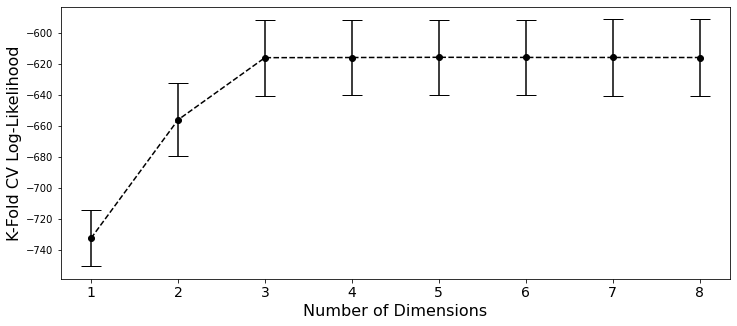

In [9]:
import pandas as pd
import joblib

res = joblib.load(open('/Users/joshua/myworkspace/glnem/analysis/pp_network/'
                       'cv_results_logit_k4_d8_n15000.pkl', 'rb'))


fig, ax = plt.subplots(figsize=(12,5))
ax.errorbar(np.arange(8), res['loglik'], yerr=res['se'], 
            linestyle='--', marker='o', color='k',
            capsize=10.)
ax.set_xticks(np.arange(8))
ax.set_xticklabels(np.arange(1,9), fontsize=14)
ax.set_xlabel('Number of Dimensions', fontsize=16)
ax.set_ylabel('K-Fold CV Log-Likelihood', fontsize=16)

## Fit  the $d_0 = 3$ Fixed Dimension Model with Gaussian Priors

In [10]:
model = GLNEM(family='bernoulli', link='logit', n_features=3, infer_dimension=False)
model.sample(Y, n_warmup=7500, n_samples=15000)

sample: 100%|███████████████████████████████████████████| 22500/22500 [06:04<00:00, 61.71it/s, 15 steps of size 2.13e-01. acc. prob=0.85]


## Calculate Posterior Predictives

In [ ]:
from glnem.gof import transitivity

res_trans = model.posterior_predictive(transitivity)
res_ssl = model_ss.posterior_predictive(transitivity)

data = pd.melt(pd.DataFrame({'Gaussian Prior ($d=3$)': res_trans,
                             'SS-IBP ($\hat{d} = 5$)': res_ssl}),
               var_name='Model')

In [8]:
from glnem.gof import degree

degrees_ssl = model_ss.posterior_predictive(degree)
degrees = model.posterior_predictive(degree)

## Posterior Predictive Comparison (Figure S4)

<IPython.core.display.Javascript object>


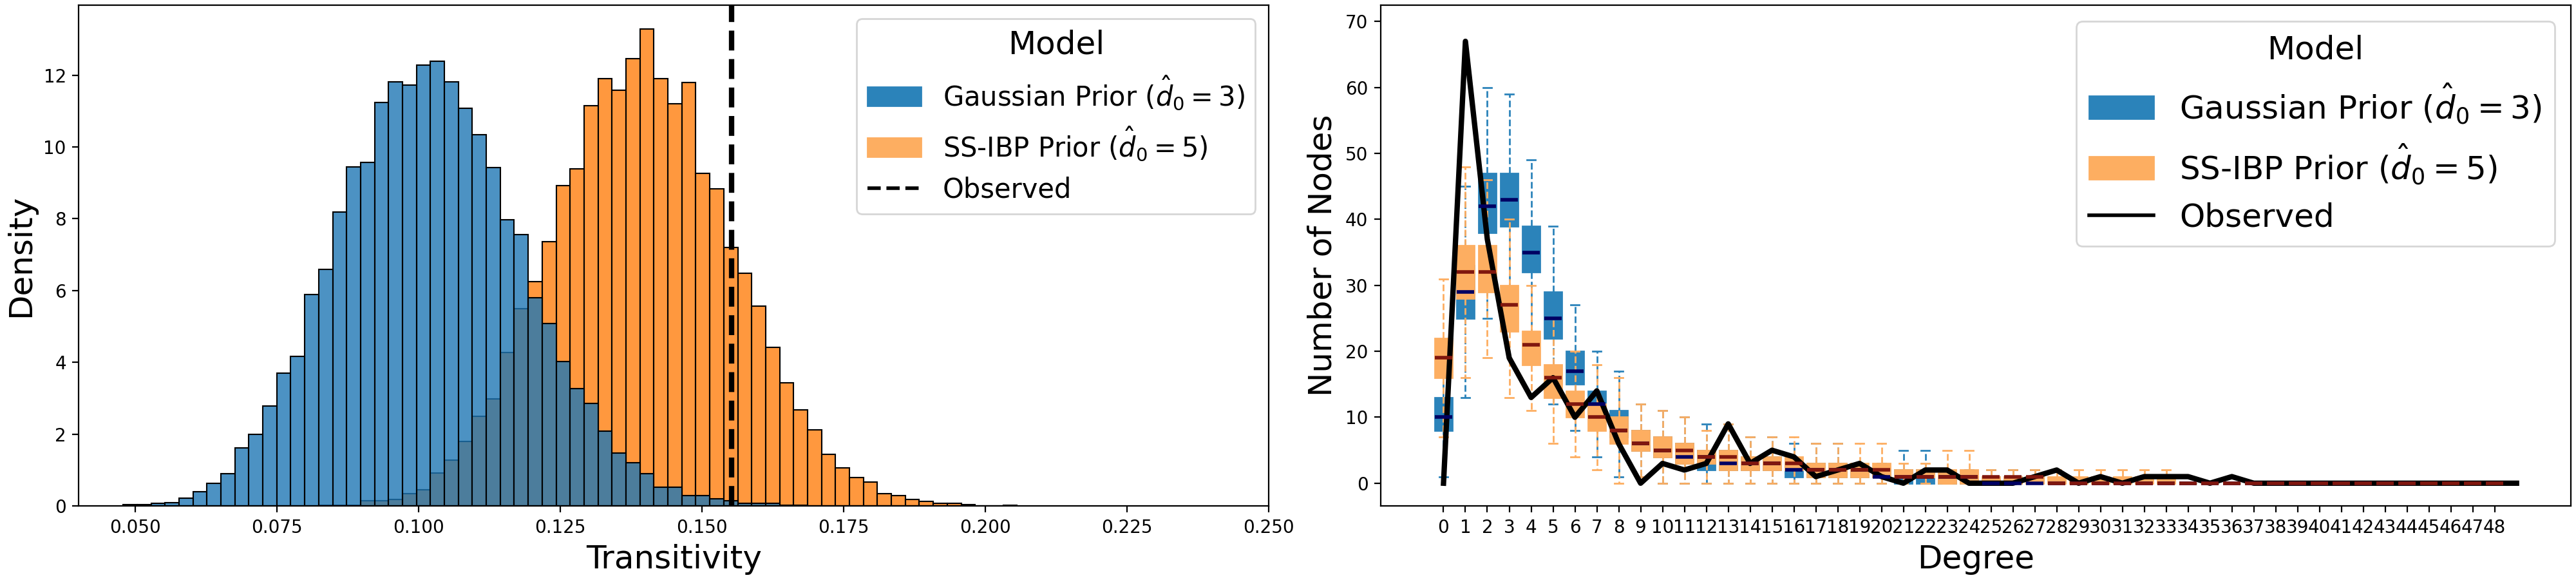

In [9]:
import seaborn as sns

from glnem.gof import degree_distribution
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

ax = plt.figure(
    constrained_layout=True, figsize=(20, 4.5)).subplot_mosaic(
    """
    AABB
    """
)

y_vec = adjacency_to_vec(Y)


# posterior predictive for transitivity statistic
sns.histplot(data, x='value', hue='Model', edgecolor='k', 
             stat='density', 
             color=['#2b83ba', '#fdae61'],
             alpha=0.8,
             ax=ax['A'])
ax['A'].axvline(transitivity(y_vec), color='k', linestyle='--', linewidth=3)
ax['A'].set_xlabel('Transitivity', fontsize=18)
ax['A'].set_ylabel('Density', fontsize=18)
ax['A'].set_xlim(0.04, 0.25)


# posterior predictives for degree distribution
color = '#a2bfCb'
color = '#2b83ba'
BOXPLOT_PROPS = {
    'boxprops': {'facecolor': color, 'edgecolor': color},
    'medianprops': {'color': '#000063', 'linewidth': 2},
    'whiskerprops': {'color': color, 'linestyle': '--'},
    'capprops': {'color': color}
}

max_degree = np.max(degrees) + 1
deg_dist = degree_distribution(degrees)
g2 = sns.boxplot(x='degree', y='count', data=deg_dist, color='w', fliersize=0,
            ax=ax['B'], **BOXPLOT_PROPS)


color = 'darkorange'
color = '#e0a481'
color = '#fdae61'
BOXPLOT_PROPS = {
    'boxprops': {'facecolor': color, 'edgecolor': color},
    'medianprops': {'color': '#80170E', 'linewidth': 2},
    'whiskerprops': {'color': color, 'linestyle': '--'},
    'capprops': {'color': color}
}
max_degree = np.max(degrees_ssl) + 1
deg_dist = degree_distribution(degrees_ssl)
g1=sns.boxplot(x='degree', y='count', data=deg_dist, color='w', fliersize=0,
            ax=ax['B'], **BOXPLOT_PROPS)
ax['B'].plot(
    np.bincount(degree(y_vec).ravel(), minlength=max_degree + 1),
    '-', color='k', linewidth=3)

handles = [
    Patch(color='#2b83ba', label='Gaussian Prior ($\hat{d}_0 = 3$)'),
    Patch(color='#fdae61', label='SS-IBP Prior ($\hat{d}_0 = 5$)'),
    Line2D([0], [0], color='k', linestyle='--', lw=2, label='Observed')
]
legend = ax['A'].legend(handles=handles, title='Model', fontsize=15)
plt.setp(legend.get_title(),fontsize=18)

handles = [
    Patch(color='#2b83ba', label='Gaussian Prior ($\hat{d}_0 = 3$)'),
    Patch(color='#fdae61', label='SS-IBP Prior ($\hat{d}_0 = 5$)'),
    Line2D([0], [0], color='k', linestyle='-', lw=2, label='Observed')
]
legend = ax['B'].legend(handles=handles, title='Model', fontsize=18)
plt.setp(legend.get_title(),fontsize=18)

ax['B'].set_ylabel('Number of Nodes', fontsize=18)
ax['B'].set_xlabel('Degree', fontsize=18)

# Sensitivity to Truncation Level $d$

# Bernoulli GLNEM ($d$ = 12)

In [23]:
model_ss_d12 = GLNEM(family='bernoulli', link='logit', n_features=12)
model_ss_d12.sample(Y, n_warmup=7500, n_samples=15000)

sample: 100%|██████████████████████████████████████| 22500/22500 [41:48<00:00,  8.97it/s, 63 steps of size 8.08e-02. acc. prob=0.87]


# Bernoulli GLNEM (d = 8)

In [27]:
model_ss_d8 = GLNEM(family='bernoulli', link='logit', n_features=8)
model_ss_d8.sample(Y, n_warmup=7500, n_samples=15000)

sample: 100%|██████████████████████████████████████| 22500/22500 [35:33<00:00, 10.55it/s, 63 steps of size 7.45e-02. acc. prob=0.88]


## Dimension Posterior Comparison (Figure S9)

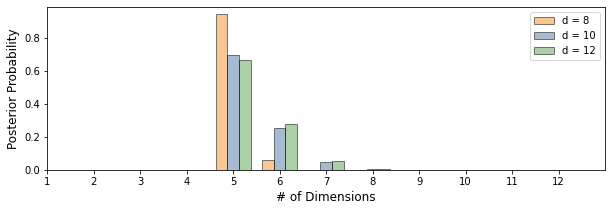

In [4]:
fig, ax = plt.subplots(figsize=(10,3))

# count number of samples with a given dimension
count_d10 = np.bincount(model_ss.samples_['z'].sum(axis=1), minlength=12)[1:]
count_d12 = np.bincount(model_d12.samples_['z'].sum(axis=1), minlength=12)[1:]
count_d8 = np.bincount(model_d8.samples_['z'].sum(axis=1), minlength=12)[1:]

ax.bar(np.arange(1, 12)-0.25, count_d8/count_d8.sum(), width=0.25, alpha=0.5, 
       color='#f28e2b', edgecolor='k', label='d = 8')
ax.bar(np.arange(1, 12), count_d10/count_d10.sum(), color='#4e79a7', width=0.25, alpha=0.5, 
       edgecolor='k', label='d = 10')
ax.bar(np.arange(1, 12)+0.25, count_d12/count_d12.sum(), color='#59a14f', 
       width=0.25, alpha=0.5, edgecolor='k', label='d = 12')
ax.set_xlim(1, 13)
ax.set_xticks(np.arange(1, 13))
ax.set_xlabel('# of Dimensions', fontsize=12)
ax.set_ylabel('Posterior Probability', fontsize=12)

ax.legend()